In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble

In [3]:
# read data
df_train=pd.read_csv("data/train.csv")
df_test=pd.read_csv("data/test.csv")

# concatenate data to clean the data and do feature engineering
frames=[df_train,df_test]
df=pd.concat(frames)

print('size of data: '+str(df.shape))
df.head()

size of data: (1309, 12)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
# search for duplicates (if found they are removed)
df = df.drop_duplicates()
df.shape

(1309, 12)

In [5]:
# no duplicates found
# now we should check which features contain a lot of NaN values
df_list_names=list(df)

for i in range(0,len(df_list_names)):
    
    num = df[df.columns[i]].isnull().sum()
    den = len(df[df.columns[i]])
    print(str(df_list_names[i])+' '+str(num))

Age 263
Cabin 1014
Embarked 2
Fare 1
Name 0
Parch 0
PassengerId 0
Pclass 0
Sex 0
SibSp 0
Survived 418
Ticket 0


In [6]:
# Obviously we do not have the data for 'Survived' feature in the test set (418)
#'Cabin' feature contains a lot of NaN values so we can remove this from the dataframe

df = df.drop(['Cabin'], axis=1) 

# let's see if we can infer the missing values from 'Fare' and 'Embarked'

missing_values_embarked=df.loc[df['Embarked'].isnull()]
missing_values_embarked

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


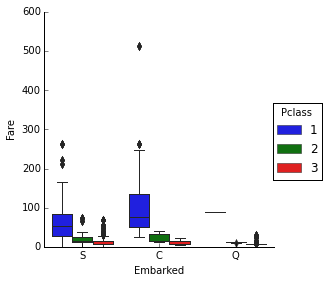

In [7]:
# we observe that both passengers where 'Embarked'=NaN have a Fare of 80$, Parch of 0 and Pclass of 1
# and are both males
# the 'Embarked' feature (the port from which the person embarked on Titanic) has mostly to do with
# the 'Fare' of the ticket and its 'Pclass', so let us see the relation between 'Embarked' and 'Fare' for
# every different 'Pclass' value (1,2,3)

slice=df[['Embarked','Fare','Pclass']]
slice=slice.dropna()

sns.factorplot(kind='box',y='Fare',x='Embarked',hue='Pclass',data=slice)

In [8]:
# based on the 2 boxplots, passengers who embarked from Cherbourg port paid close to 80$ and purchased a first class
# ticket.So we deduce that with a high probability the missing values can be replaced by C

df.loc[df['PassengerId']==62,'Embarked']='C'
df.loc[df['PassengerId']==830, 'Embarked']='C'

In [9]:
# see the missing value in feature 'Fare'
missing_values_fare=df.loc[df['Fare'].isnull()]

missing_values_fare

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [10]:
# estimate missing 'Fare' value by calculating median value of passengers embarked from S for a 3rd class ticket

slice=df.loc[(df['Embarked'] == 'S') & (df['Pclass']==3) & (df['Fare'].notnull())]
slice['Fare'].median()

8.05

In [11]:
# set missing value to 8.05$

df.loc[df['PassengerId']==1044,'Fare']=8.05

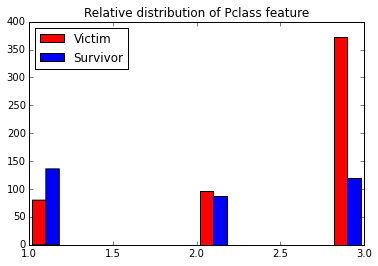

In [12]:
# Let us now consider the 'Pclass' feature.
# It is known that during the tragedy a large portion of the victimes came from the 3rd class. 
# Let us see the distribution of the victims and the survivors for people in each class.

Survivors = df[df.Survived ==1]
Victims = df[df.Survived == 0]
x1 = np.array(Victims['Pclass'])
x2 = np.array(Survivors['Pclass'])
plt.hist([x1, x2], label=['Victim', 'Survivor'],color = ['r', 'b'])
plt.legend(loc = 'upper left')
plt.title('Relative distribution of Pclass feature')
plt.show()

In [13]:
# So indeed that was the case in our dataset. Most of the victims came from the 3rd class.
# And most of the survivors come from the 1st class. The 2nd class is not discriminative.
# As Pclass is a categorical feature we will apply the one-hot encoding scheme and we will
# transform the feature into 3 new binary features that contain only a value of 0 or 1.

dummies=pd.get_dummies(df['Pclass'],prefix='Pclass_')
df = pd.concat([df,dummies],axis=1)

# we then drop the 'Pclass' feature
df = df.drop(['Pclass'], axis=1)
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Pclass__1,Pclass__2,Pclass__3
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,male,1,0.0,A/5 21171,0,0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,female,1,1.0,PC 17599,1,0,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,0,0,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,female,1,1.0,113803,1,0,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,male,0,0.0,373450,0,0,1


In [14]:
# we proceed in the same way for the 'Sex' feature
# 2 binary features are created

dummies=pd.get_dummies(df['Sex'],prefix='Sex_')
df = pd.concat([df,dummies],axis=1)

# we then drop the 'Sex' feature
df = df.drop(['Sex'], axis=1)
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass__1,Pclass__2,Pclass__3,Sex__female,Sex__male
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,0,1,0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,0,1,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,0,0,1,1,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,0,0,1,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,0,1,0,1


In [15]:
# we proceed in the same way for the 'Embarked' feature
# 3 binary features are created

dummies=pd.get_dummies(df['Embarked'],prefix='Embarked_')
df = pd.concat([df,dummies],axis=1)

# we then drop the 'Embarked' feature
df = df.drop(['Embarked'], axis=1)
df.head()

,Age,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass__1,Pclass__2,Pclass__3,Sex__female,Sex__male,Embarked__C,Embarked__Q,Embarked__S
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,0,1,0,1,0,0,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,0,1,0,1,0,0
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,0,0,1,1,0,0,0,1
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,0,0,1,0,0,0,1
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,0,1,0,1,0,0,1


In [16]:
# concerning the 'Age' feature, one way to fill the specific missing values is to 
# fill them with the median of all the ages.

df['Age'] = df.Age.fillna(df.Age.median())

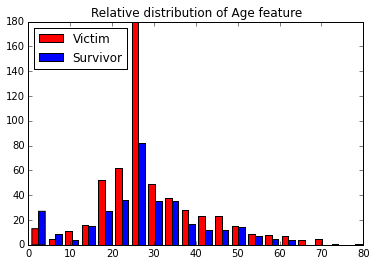

In [17]:
# but let us see what is the distribution of survivors and victims
# when compared with the age of the passenger

Survivors = df[df.Survived ==1]
Victims = df[df.Survived == 0]
x1 = np.array(Victims['Age'])
x2 = np.array(Survivors['Age'])
plt.hist([x1, x2], label=['Victim', 'Survivor'],bins=20,color = ['r', 'b'])
plt.legend(loc = 'upper left')
plt.title('Relative distribution of Age feature')
plt.show()


In [18]:
# we observe that there is a great proportion of children that have survived
# and a great proportion of people in their 20s that died..
# so it seems that a new feature can be created, determining whether a person is a child
# in order to strengthen the weight of the age feature

df['Child'] = np.where(df.Age < 8,1,0)

In [19]:
# in order to take advantage of the 'Name' feature
# we have to notice that the name has the following form:
# name1, title. name2 name3 (surname) (optional surname)
# we can indeed extract the title and create a distinct feature

#let's first see the different titles
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
    
print(titles)

{'Col', 'Sir', 'Rev', 'Ms', 'Mr', 'Mlle', 'Lady', 'Major', 'Dr', 'Capt', 'Don', 'Mme', 'Dona', 'Jonkheer', 'the Countess', 'Master', 'Miss', 'Mrs'}


In [20]:
# as we do not want to add as many features as all the different titles that exist
# let us group the titles into title categories

Title_Categories = {
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Mr",
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Dr": "Officer",
    "Rev": "Officer",
    "Jonkheer": "Royal",
    "Don": "Royal",
    "Sir" : "Royal",
    "the Countess":"Royal",
    "Lady" : "Royal"
}

In [21]:
df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
df['Title'] = df.Title.map(Title_Categories)
df.head()

,Age,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass__1,Pclass__2,Pclass__3,Sex__female,Sex__male,Embarked__C,Embarked__Q,Embarked__S,Child,Title
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0,0,1,0,1,0,0,1,0,Mr
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1,0,0,1,0,1,0,0,0,Mrs
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,0,0,1,1,0,0,0,1,0,Miss
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1.0,113803,1,0,0,1,0,0,0,1,0,Mrs
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,0,0.0,373450,0,0,1,0,1,0,0,1,0,Mr


In [22]:
# we proceed and create as many dummy features 
# as the number of different titles

dummies=pd.get_dummies(df['Title'],prefix='Title_')
df = pd.concat([df,dummies],axis=1)

# we then drop the 'Title' and 'Name' features
df = df.drop(['Title'], axis=1)
df = df.drop(['Name'], axis=1)
df.head()

,Age,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Pclass__1,Pclass__2,Pclass__3,...,Sex__male,Embarked__C,Embarked__Q,Embarked__S,Child,Title__Miss,Title__Mr,Title__Mrs,Title__Officer,Title__Royal
0,22.0,7.2500,0,1,1,0.0,A/5 21171,0,0,1,...,1,0,0,1,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1.0,PC 17599,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,3,0,1.0,STON/O2. 3101282,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,35.0,53.1000,0,4,1,1.0,113803,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,35.0,8.0500,0,5,0,0.0,373450,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [23]:
# last feature to treat: 'Ticket'
#let's see how many prefixes exist in the tickets

def process_ticket(ticket):
    
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return(ticket[0])
    else:
        return('U')
    
tickets = set()
for ticket in df['Ticket']:
    
    tickets.add(process_ticket(ticket))

print (str(len(tickets)))


37


In [24]:
# different prefixes are:
tickets

{'A',
 'A4',
 'A5',
 'AQ3',
 'AQ4',
 'AS',
 'C',
 'CA',
 'CASOTON',
 'FC',
 'FCC',
 'Fa',
 'LINE',
 'LP',
 'PC',
 'PP',
 'PPP',
 'SC',
 'SCA3',
 'SCA4',
 'SCAH',
 'SCOW',
 'SCPARIS',
 'SCParis',
 'SOC',
 'SOP',
 'SOPP',
 'SOTONO2',
 'SOTONOQ',
 'SP',
 'STONO',
 'STONO2',
 'STONOQ',
 'SWPP',
 'U',
 'WC',
 'WEP'}

In [25]:
#create dummies for 'Ticket' feature
df['Ticket'] = df['Ticket'].map(process_ticket)
dummies = pd.get_dummies(df['Ticket'], prefix='Ticket')
df = pd.concat([df, dummies], axis=1)

#drop 'Ticket' feature
df.drop('Ticket', inplace=True, axis=1)
df.head()

,Age,Fare,Parch,PassengerId,SibSp,Survived,Pclass__1,Pclass__2,Pclass__3,Sex__female,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_U,Ticket_WC,Ticket_WEP
0,22.0,7.2500,0,1,1,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,2,1,1.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,3,0,1.0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,53.1000,0,4,1,1.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,35.0,8.0500,0,5,0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


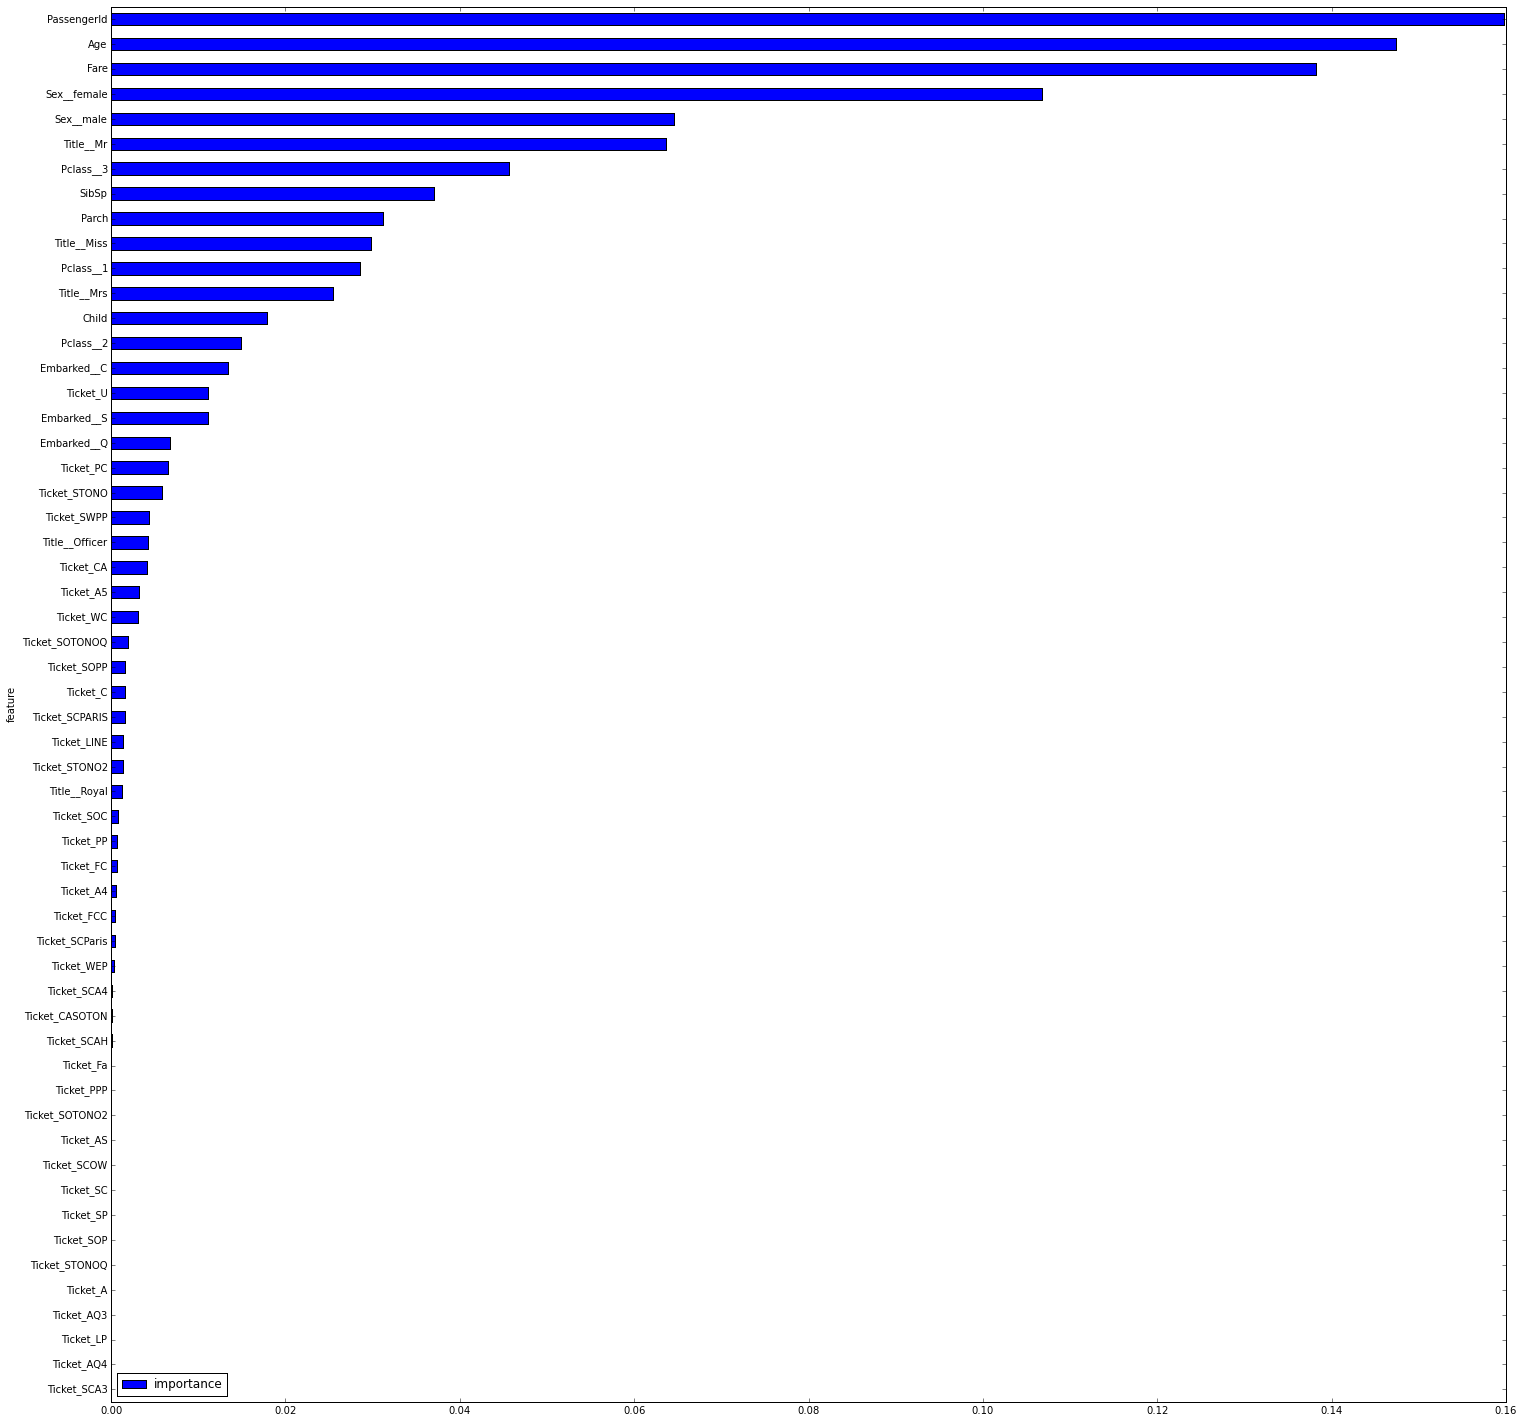

In [26]:
# we ended up with a lot of features so let's try to reduce them
# by doing feature selection
# we can use the random forest classifier to compute feature importances
y_train=df[df['Survived'].notnull()]['Survived']
X_train=df[df['Survived'].notnull()].drop(['Survived'],axis=1)


clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

In [27]:
# let's transform the train and test sets to reduced 
# versions based on the feature selection procedure

model = SelectFromModel(clf, prefit=True)
X_train_reduced = model.transform(X_train)

X_test=df[df['Survived'].isnull()].drop(['Survived'],axis=1)
X_test_reduced= model.transform(X_test)


In [28]:
#clf = ensemble.GradientBoostingClassifier()
#clf=SVC(kernel='linear')
#clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(100,), random_state=1)
#clf=RandomForestClassifier()

# use logistic regression with 5-fold cross validation to train our classifier and see the accuracy scores
clf=LogisticRegression()
xval = cross_val_score(clf, X_train_reduced, y_train, cv = 5, scoring='accuracy')
xval


array([0.81564246, 0.79888268, 0.79213483, 0.78089888, 0.83050847])

In [29]:
# now let's predict the missing values from the test set using the selected classifier
X_test=df[df['Survived'].isnull()].drop(['Survived'],axis=1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [34]:
# compute probabilities for each preciction

probabilities_test=clf.predict_proba(X_test)
# for example the first entry of the test set
# has a ~88% probability of not surviving (Survived=0)
probabilities_test[0]

array([0.87634062, 0.12365938])

In [31]:
unique, counts = np.unique(y_pred, return_counts=True)

for key,value in zip(unique, counts):
    print (str(key) + ' '+ str(value) +' '+ str(value/len(y_pred)))
    
# predicted ~63% people to die and ~37% to survive (261 lived and 157 die out of 418)


0.0 261 0.6244019138755981
1.0 157 0.37559808612440193


In [32]:
# select the 2 columns PassengerId and Survived
df_output=df[['PassengerId','Survived']]
# select the test set
df_output=df_output.loc[df_output['PassengerId']>=892]
# fill NaN values with the predicted value
df_output['Survived'] = np.where(df_output['Survived'].isnull(), y_pred,np.nan)
df_output.head()

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0


In [33]:
# produce a csv output in the format needed by Kaggle
df_output['Survived'] = df_output['Survived'].astype(int)
df_output.to_csv('out.csv',index=False)

# Kaggle score 0.78947